# Linear Regression

## Using Gradient Descent for Linear Regression

In [1]:
import numpy as np
import seaborn as sns

import bokeh.plotting as bp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.datasets import make_regression 
from scipy import stats 
from bokeh.models import  WheelZoomTool, ResetTool, PanTool

W = 450
H = 450
bp.output_notebook()
%matplotlib notebook

plt.rcParams["animation.html"] = "jshtml" 

Loading BokehJS ...

### Linear regression

Let's apply Gradient descent concept to *linear regression* in order to find line coefficients that fit the data well.

Let's make up some data with noise and plot the resulting data. In this example, it doesn't really matter what the data represent - it could be any two variables that are related to each other, like the height and weight of a person. Additionally, I calculated the line of best fit through the least squares implementation in the `scipy` package, in order to compare the results from gradient descent to the line of best fit. As in our first example, we will use this solution to test how well gradient descent performs.

In [2]:
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=10,
                       random_state=2015)


slope, intercept, _,_,_ = stats.linregress(x[:,0],y)
best_fit = x[:,0] * slope + intercept

In [3]:
# <!-- collapse=True -->
source = bp.ColumnDataSource(
        data=dict(
            x=x.flatten(),
            y=y        )
    )


TOOLS = [ WheelZoomTool(), ResetTool(), PanTool()]

From the plot, you can see that there is a linear relation between the two variables. Let's calculate the regression line through gradient descent. From the example above, we know that we need two things to do so:

* a cost function.
* a way to minimize the cost by updating our parameters (update function)

For a simple regression, we have two parameters: the slope and the intercept. In this example, we express both by the vector $\theta$ with length 2. To find the best line, we have to iteratively find the values of theta that minimize the cost. While in the first example, we defined the cost simple as the squared distance from the true minimum, the cost function $J(\theta)$ for linear regression is a little more complex and defined as follows: 

$$\begin{align}
J(\theta) =  \frac{1}{2m}(X\theta-y)^{T}(X\theta-y)
\end{align}$$

which translates as: For the current $\theta$, predict the $y$ values, and subtract the actual $y$ value. Then square this error ($X\theta-y$). This measures how far away the predicted values are from the actual value of $y$. The overall cost is scaled by $m$, the number of data points we have in $y$, in our example 100.

To minimize this cost function, the theta values have to changed accordingly. The update function is defined as:

$$\begin{align}
\theta := \theta - \alpha \frac{1}{m} (X^{T}(X\theta-y))
\end{align}$$

Theta is adjusted relative to the error of our predicted values, and then scaled by $m$. $\alpha$ is the step-size: As in the earlier example, this value has to be chosen carefully. If you are interested in the mathematical derivations of these functions, you can read through Andrew Ng's [lecture notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf) on the topic, but for this example it suffices to know that they derive on partial derivatives, and thus on the gradient.

Below, the function `gradient_descent` implements the two functions above and adjusts theta iteratively for `iters` iterations. The code is pretty verbose, so you should be able to match the code to the functions above.

In [4]:
def gradient_descent(x, y, iters, alpha):
    costs = []
    m = y.size # number of data points
    theta = np.random.rand(2) # random start
    history = [theta] # to store all thetas
    preds = []
    for i in range(iters):
        pred = np.dot(x, theta)
        error = pred - y 
        cost = np.sum(error ** 2) / (2 * m)
        costs.append(cost)
        
        if i % 25 == 0: preds.append(pred)

        gradient = x.T.dot(error)/m 
        theta = theta - alpha * gradient  # update
        history.append(theta)
        
    return history, costs, preds

We can now call the function on our data. First, we have to insert a column of 1's in order for the matrix algebra to work out. We define the step size and the number of iterations, and then call the function.

In [5]:
x = np.c_[np.ones(x.shape[0]), x] 

In [6]:
alpha = 0.001 # set step-size
iters = 5000 # set number of iterations
history, cost, preds = gradient_descent(x, y, iters, alpha)
theta = history[-1]

Here is the result after 5000 iterations, compared to the values from the least squares algorithm. The results are pretty close, and the line seems to have a good fit:

In [7]:
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))

Gradient Descent: 1.20, 62.81
Least Squares: 1.49, 63.42


In [8]:
# <!-- collapse=True -->
pred = np.dot(x, theta)

source = bp.ColumnDataSource(
        data=dict(
            x=x[:, 1].flatten(),
            y=y        )
    )


TOOLS = [ WheelZoomTool(), ResetTool(), PanTool()]

fig = bp.figure(width=W, plot_height=H, 
                title='Line fit by gradient descent',  
                tools=TOOLS )
s1 = fig.circle('x', 'y', size=10, color='navy', alpha=0.5, source=source)
s2 = fig.line(x[:, 1].flatten(), pred, color='orange', line_width=3)
fig.title.text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

The plot below shows how the values of theta change over time. The random starts sets theta to low values, and then gradient descent adjusts the slope to a much higher value, while changing the intercept at the same time.

In [9]:
# <!-- collapse=True -->
TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]

to_plot = [(x[0],x[1], c) for x, c in  (zip(history[::100], cost[::100]))]
a,b,c = zip(*to_plot)



fig = bp.figure(width=W, plot_height=H, 
                title='Theta values over time',  
                tools=TOOLS,
                x_axis_label='Intercept',
                y_axis_label='Slope')
s1 = fig.circle(a,b, size=5, color='navy', alpha=0.5)
fig.title.text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

As in the first example, the cost should decrease over iterations - if it is not, there is something wrong with your update function! Below, we see that the cost is indeed decreasing, and approaching zero. Depending on your data, and how linear it is, the cost will never reach zero but hover around a higher value. To test this, you can increase the `noise` parameter in the `make_regression` function that generated our data.

In [10]:
# <!-- collapse=True -->
TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]
x1, y1 = (zip(*enumerate(cost)))

fig = bp.figure(width=590, plot_height=350, 
                title='Loss over iterations',
                x_axis_label='Iteration',
                y_axis_label='Loss',
                tools=TOOLS )
s1 = fig.line(x1,y1, line_width=4, color='navy', alpha=0.5)
# remaining cost is tied directly to the noise of the distribution,
# ergo it's also a measure of fit
fig.title.text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

Below is an animated plot that shows the changing line (green) defined by the theta values over time. It starts with our random thetas close to 0 which results in a horizontal line, and then slowly approaches the line of best fit (red). As evident in the cost plot, the improvement slows down over subsequent iterations and barely changes at the end.

<IPython.core.display.Javascript object>


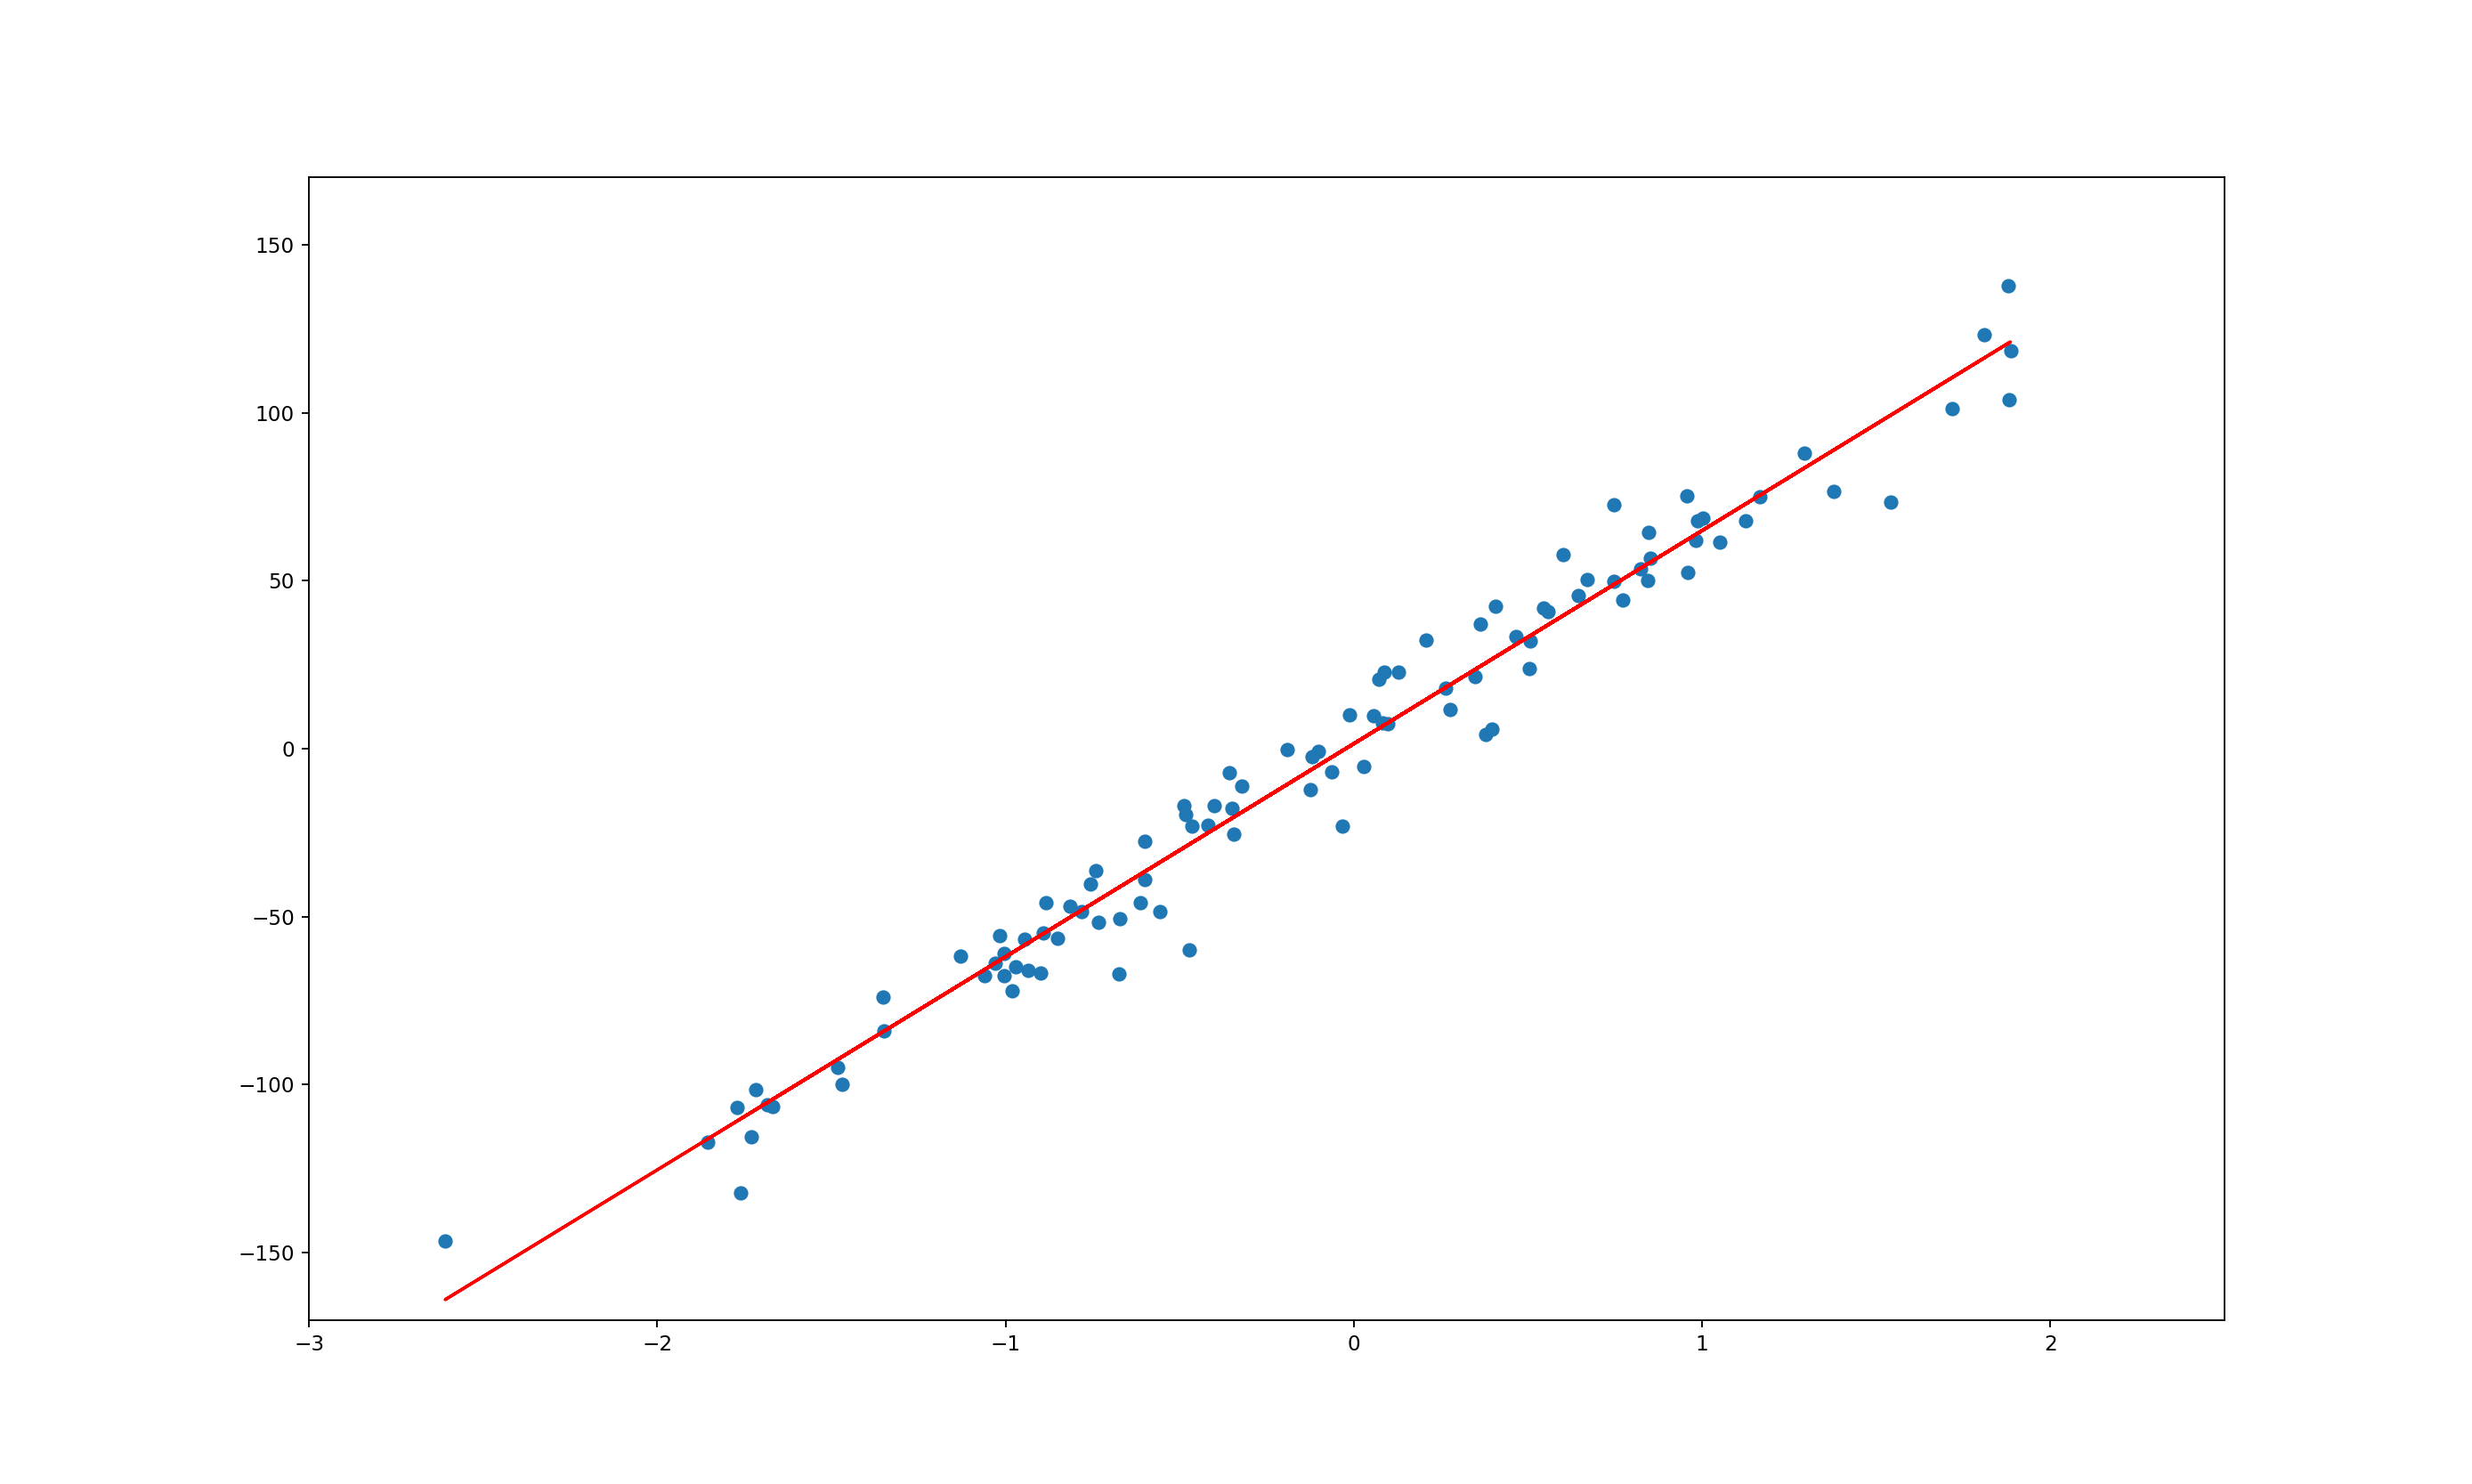

In [11]:
# <!-- collapse=True -->

def init():
    line.set_data([], [])
    return line,

def animate(i):
    ys = preds[i]
    line.set_data(x[:, 1], ys)
    return line,

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(x[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(x[:,1], best_fit, 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(preds), interval=100)
anim

Both examples here only have one minimum, and are [convex functions](https://en.wikipedia.org/wiki/Convex_function). This means that no matter where we start (initial values of theta), we arrive at the minimum. *This is not always the case*. 


The plot below shows the convexity of the linear regression example, with the red point denoting the minimum. No matter where on the plane we start, gradient descent works as a compass pointing to the minimum.

<IPython.core.display.Javascript object>


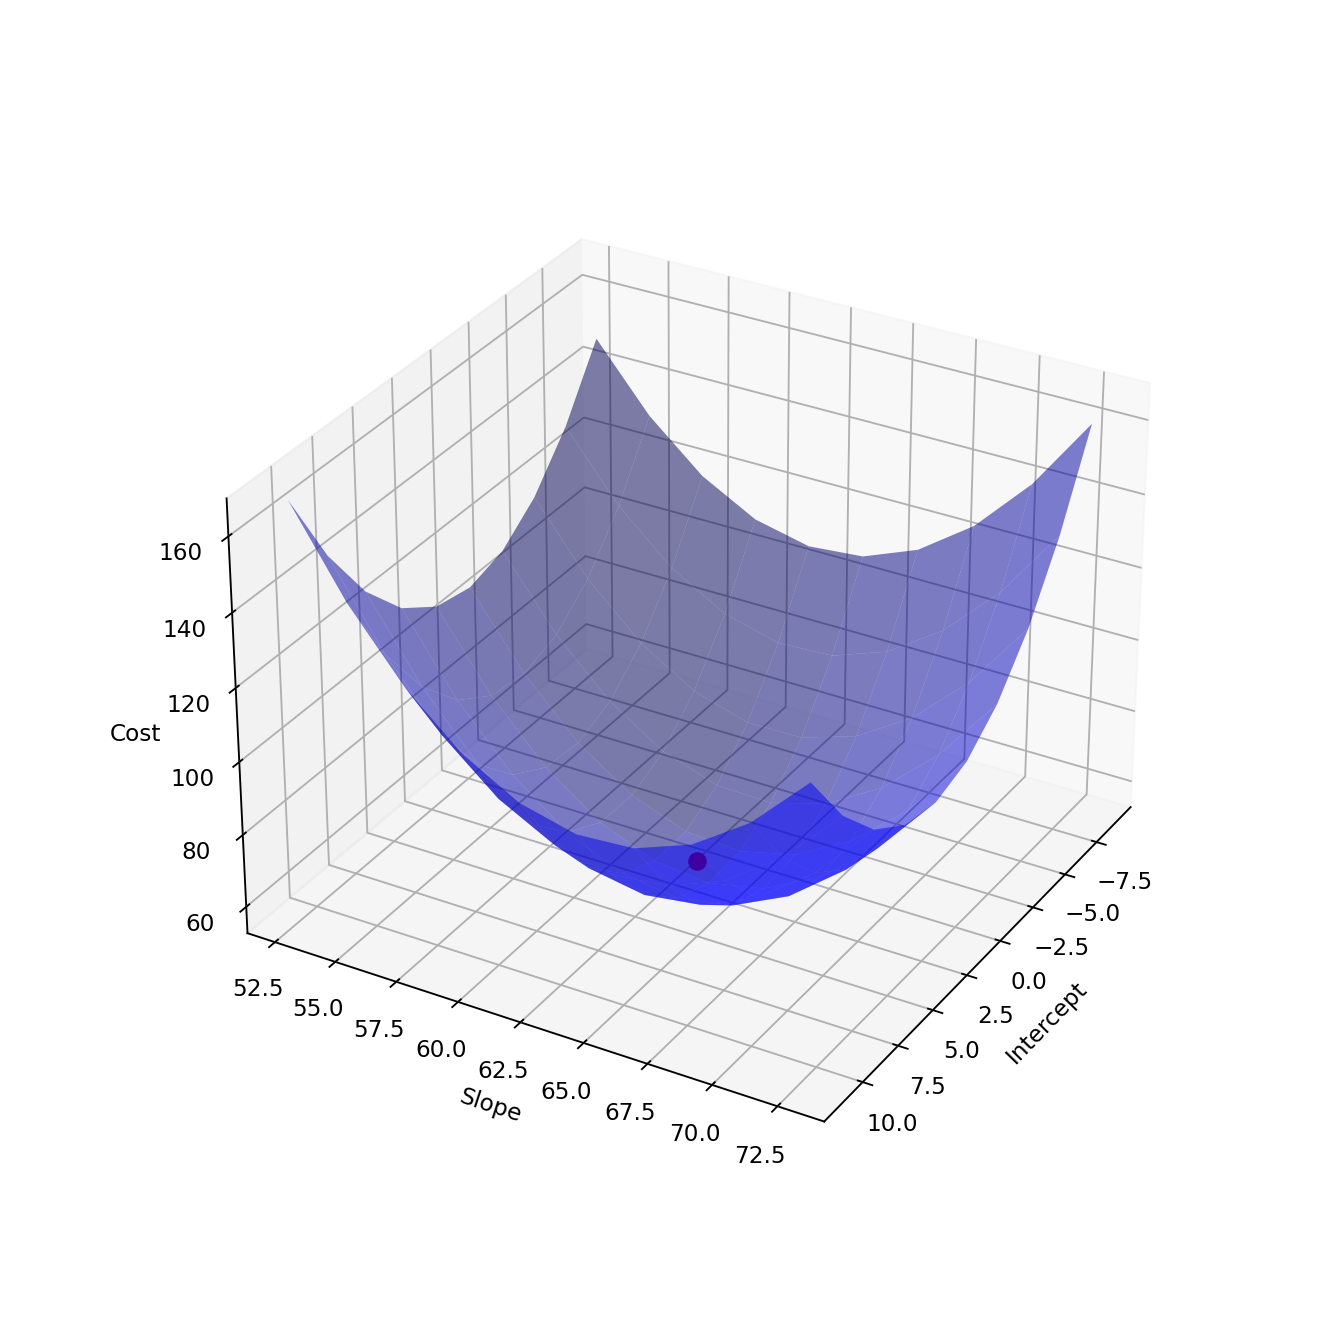

In [12]:
# <!-- collapse=True -->
from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - y)**2)/(2*Y.size)

ms = np.linspace(theta[0] - 10 , theta[0] + 10, 10)
bs = np.linspace(theta[1] - 10 , theta[1] + 10, 10)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(x, y, theta) 
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);


 If the number of data points is very high, using a standard least squares solver might be too expensive, and (stochastic) gradient descent might give you a solution that is as good in terms of test-set error as a more precise solution, with a run-time that is orders of magnitude smaller